In [1]:
source("functions/data.R")
source("functions/process.R")
source("functions/simulations.R")

Loading required package: httr
Loading required package: dygraphs
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: IRdisplay
Loading required package: htmlwidgets
Loading required package: repr
Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



In [2]:
# Define dataframes
ETH <- get_data("ETH",params$start,params$end,params$period,52,FALSE)
XRP <- get_data("XRP",params$start,params$end,params$period,52,FALSE)
XMR <- get_data("XMR",params$start,params$end,params$period,52,FALSE)
LTC <- get_data("LTC",params$start,params$end,params$period,52,FALSE)

high <- cbind(ETH$high,XRP$high,XMR$high,LTC$high)
low <- cbind(ETH$low,XRP$low,XMR$low,LTC$low)
open <- cbind(ETH$open,XRP$open,XMR$open,LTC$open)
close <- cbind(ETH$close,XRP$close,XMR$close,LTC$close)

# Rename all the columns
colnames(high)  <- currency_vec
colnames(low) <- currency_vec
colnames(open) <- currency_vec
colnames(close) <- currency_vec
prices_vec <- list(high,low,open,close)

No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.


In [3]:
dim(ETH)

[1] 8453    7

In [46]:
# simulation function, the agent randomizes the weight vector at each step
# params: n_hist, number of timesteps in the past for price history
# params: n_episodes, number of episodes in the simulation
simulate_random <- function(n_hist,n_episodes){
    prev_v <- tail(head(close,n_hist-1),1) ## initialize first previous price vector
    returns <- 0

    # simulation
    for(i in 0:n_episodes){

        # generates random action (portfolio vector)
        random_action <- function(n_assets){
        x <- runif(n_assets+1)
        return(x/sum(x))
        }

        # get price dataframes based on current time steps
        hi <- head(high,i+n_hist)
        lo <- head(low,i+n_hist)
        price <- head(close,i+n_hist)

        wt <- random_action(4)
        curr_v <- tail(price,1)
        yt <- getPriceRelativeVec(prev_v,curr_v)
        rt <- getLogReturns(yt,wt)

        print(paste0("episode ",i))
        print(cat("wt: ",wt))
        print(cat("yt: ",yt))
        print(cat("rt: ",rt))
        print("=================================")

        prev_v <- curr_v # set previous price as current price
        returns <- update_returns(i+1,returns,yt,wt)
    }

    print(paste("average returns for this simulation: ", returns))
}

simulate_random(10,100)

[1] "episode 0"
wt:  0.09927672 0.1916044 0.3243538 0.1007339 0.2840312NULL
yt:  1 1.008287 1.007063 1.002357 0.9975541NULL
rt:  0.003415516NULL
[1] "================================="
[1] "episode 1"
wt:  0.09636395 0.3916544 0.2671937 0.01974814 0.2250399NULL
yt:  1 0.9733332 0.9667532 0.9824279 0.9903786NULL
rt:  -0.02208175NULL
[1] "================================="
[1] "episode 2"
wt:  0.3364182 0.02003909 0.2619481 0.1246081 0.2569865NULL
yt:  1 1.019516 1.01021 1.003953 1.014365NULL
rt:  0.007223558NULL
[1] "================================="
[1] "episode 3"
wt:  0.002945288 0.24775 0.3869249 0.3111157 0.05126411NULL
yt:  1 0.9599102 0.9571809 0.9760407 0.9683675NULL
rt:  -0.03622402NULL
[1] "================================="
[1] "episode 4"
wt:  0.2400109 0.1775872 0.1913318 0.1574327 0.2336375NULL
yt:  1 0.9734715 0.9888858 0.990435 0.9867474NULL
rt:  -0.01150569NULL
[1] "================================="
[1] "episode 5"
wt:  0.2284325 0.0007900176 0.1911992 0.2369632 0.342

In [33]:
# Function that gives actions table for n samples and n_curren currencies
get_actions_table <- function(n_samples,n_curren,state_vec){
    action_mat <- matrix(NA,nrow=n_samples,ncol=n_curren+1)
    for(i in 1:n_samples)
        action_mat[i,] <- random_action(n_curren)
    return(action_mat)
}

# Simulation function where the agent randomly samples actions at each step and observes next rewards
simulate_samples <- function(n_samples,n_episodes){
    price <- head(close,2) # initializes the price dataframe as the first 2 price vectors
    st <- getPriceRelativeVec(price[1,],price[2,]) # get first price relative vector (first state)
    prev_v <- tail(price,1) # initializes first price vector v
    training_mat <- matrix(nrow=1,ncol=11) # initialize training matrix for training data
    
    for(i in 0:n_episodes){
        # get price dataframe of current time step
        price <- head(close,i+1)
        
        # get the current v
        curr_v <- tail(price,1)
        
        # get price change
        yt <- getPriceRelativeVec(prev_v,curr_v)
        
        # sample actions
        action_mat <- get_actions_table(n_samples,4)
        
        # get rewards for each sampled action
        reward_vec <- c()
        for(j in 1:n_samples)
            reward_vec <- c(reward_vec,getLogReturns(yt,action_mat[j,]))
        
        # append rewards to matrix
        action_mat <- cbind(action_mat,reward_vec)
        
        # Add state columns to matrix
        for(val in rev(st))
            action_mat <- cbind(rep(val,n_samples),action_mat)
        
        # Concatenate matrix to training data
        training_mat <- rbind(training_mat,action_mat)
        
        print(paste0("episode ",i))
        print(action_mat)
        print(cat("st: ",st))
        print(cat("yt: ",yt))
        print("=================================")
        
        # update price vector
        prev_v <- curr_v
        
        # update state vector
        st <- yt
    }
    return(training_mat[-1,])
}

simulate_samples(10,10)

[1] "episode 0"
                                                                      
 [1,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.209418452 0.16600517
 [2,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.123708440 0.25510822
 [3,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.223056022 0.21702411
 [4,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.006938632 0.38705552
 [5,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.185096833 0.12303158
 [6,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.329482098 0.07960692
 [7,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.181111262 0.29145277
 [8,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.148944818 0.24346293
 [9,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.301588760 0.08882256
[10,] 1 0.9349467 0.9347246 0.9631573 0.9576903 0.064937472 0.33707658
                                       reward_vec
 [1,] 0.23555559 0.32354708 0.06547371 0.04235927
 [2,] 0.25434087 0.16348641 0.20335605 0.04950391
 [3,] 0.29851500 0.12464841 0.13675645 0.04569656
 [4

,,,,,,,,,,reward_vec
1,0.9349467,0.9347246,0.9631573,0.9576903,0.209418452,0.16600517,0.23555559,0.323547083,0.06547371,0.04235927
1,0.9349467,0.9347246,0.9631573,0.9576903,0.123708440,0.25510822,0.25434087,0.163486409,0.20335605,0.04950391
1,0.9349467,0.9347246,0.9631573,0.9576903,0.223056022,0.21702411,0.29851500,0.124648413,0.13675645,0.04569656
1,0.9349467,0.9347246,0.9631573,0.9576903,0.006938632,0.38705552,0.31780897,0.083006084,0.20519079,0.05955610
1,0.9349467,0.9347246,0.9631573,0.9576903,0.185096833,0.12303158,0.38282139,0.288008295,0.02104190,0.04615899
1,0.9349467,0.9347246,0.9631573,0.9576903,0.329482098,0.07960692,0.01625313,0.256793703,0.31786415,0.03008276
1,0.9349467,0.9347246,0.9631573,0.9576903,0.181111262,0.29145277,0.12288255,0.098107460,0.30644595,0.04511851
1,0.9349467,0.9347246,0.9631573,0.9576903,0.148944818,0.24346293,0.22150523,0.190261482,0.19582553,0.04720595
1,0.9349467,0.9347246,0.9631573,0.9576903,0.301588760,0.08882256,0.14201159,0.267776327,0.19980076,0.03456318
1,0.9349467,0.9347246,0.9631573,0.9576903,0.064937472,0.33707658,0.16671997,0.319279853,0.11198613,0.05093730


In [72]:
# simulates contextual bandits problem
# params
# n_curren: number of currencies in proble (including cash)
# n_steps: number of timesteps in the episode
# alpha: learning rate of the action preference functions
# window_size: size of rolling window of asset prices to consider in the action preferences
# discount: discount factor of previous price changes
simulate_contextual1 <- function(n_curren,n_steps,alpha,window_size,discount){
    
    Ht <- rep(0,5) # initialize preference vector
    
    # Initialize weight vector for moving average window
    weight_vec <- c()
    for(k in 0:(window_size-1))
        weight_vec <- c(weight_vec,discount^k)
    weight_vec <- rev(weight_vec)
    
    price <- head(close,window_size+1) # initializes the price dataframe as the first 2 price vectors
    #st <- getPriceRelativeVec(price[1,],price[2,]) # get first price relative vector (first state)
    
    # history vector of price changes
    history <- getPriceRelativeVec(price[1,],price[2,])
    for(h in 2:window_size){
        history <- rbind(history,getPriceRelativeVec(price[h,],price[h+1,]))
    }
    
    # Define state st as vector of discounted previous relative changes
    st <- weight_vec %*% history
    
    prev_v <- tail(price,1) # initializes first price vector v
    
    # Define reward vecs and random action reward vectors
    Rvec <- c()
    Rvec_random <- c()
    Rvec_market <- c()
    market_average <- rep(1/5,5)
    
    # initialize matrices
    piMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
    hMat <- matrix(Ht,nrow=1,byrow=T)
    yMat <- matrix(rep(0,n_curren),nrow=1,byrow=T)
    
    for(i in window_size:n_steps){
        # get price dataframe of current time step
        price <- head(close,i+2)
        # get the current v
        curr_v <- tail(price,1)
        # get price change
        yt <- getPriceRelativeVec(prev_v,curr_v)
        
        # update history matrix
        history <- rbind(tail(history,window_size-1),yt)
        
        # preference vector for state s (element-wise multiplication of Ht and st)
        Ht_s <- st * Ht
        
        # Compute pivec (softmaxes for each currency)
        piVec <- c()
        for(a in 1:n_curren)
            piVec <- c(piVec,get_softmax(a,Ht_s))
        
        # get the prefered action
        action <- which.max(piVec)
        
        # get the log returns for our action (in this case our action is the softax)
        rt <- exp(getLogReturns(yt,piVec))
        Rvec <- c(Rvec,rt)
        
        # Reward for random action
        Rvec_random <- c(Rvec_random,exp(getLogReturns(yt,random_action(4))))
        
        # Reward for market average
        Rvec_market <- c(Rvec_market,exp(getLogReturns(yt,market_average)))
        
        # Update preference vector
        Ht <- get_update(rt,Rvec,Ht,action,alpha)
        
#         print(log(yt))
#         print(Ht)
#         print(piVec)
#         print("=========================================")
        
#         print(paste0("episode",i))
#         print(cat("Ht: ", Ht))
#         print(cat("Ht_s: ", Ht_s))
        # print(cat("piVec: ", piVec))
#         print(cat("rt: ", rt))
        # print("==============================")
        
        prev_v <- curr_v
        st <- weight_vec %*% history
        
        # append to matrices
        piMat <- rbind(piMat,piVec)
        hMat <- rbind(hMat,Ht)
        yMat <- rbind(yMat,yt)
            
    }
    
    return_list <- list(prod(Rvec),prod(Rvec_market),piMat,hMat,yMat,cumprod(Rvec),cumprod(Rvec_market))
    names(return_list) <- c("AgentRt","mktAve","actions","prefs","changes","AgentVec","mktVec")
    
#     print(prod(Rvec))
#     print(prod(Rvec_random))
  #  print(prod(Rvec_market))
    # return(c(prod(Rvec),prod(Rvec_market)))
    return(return_list)
    
}

In [145]:
test.run <- simulate_contextual1(5,nrow(close),0.3,10,0.8)

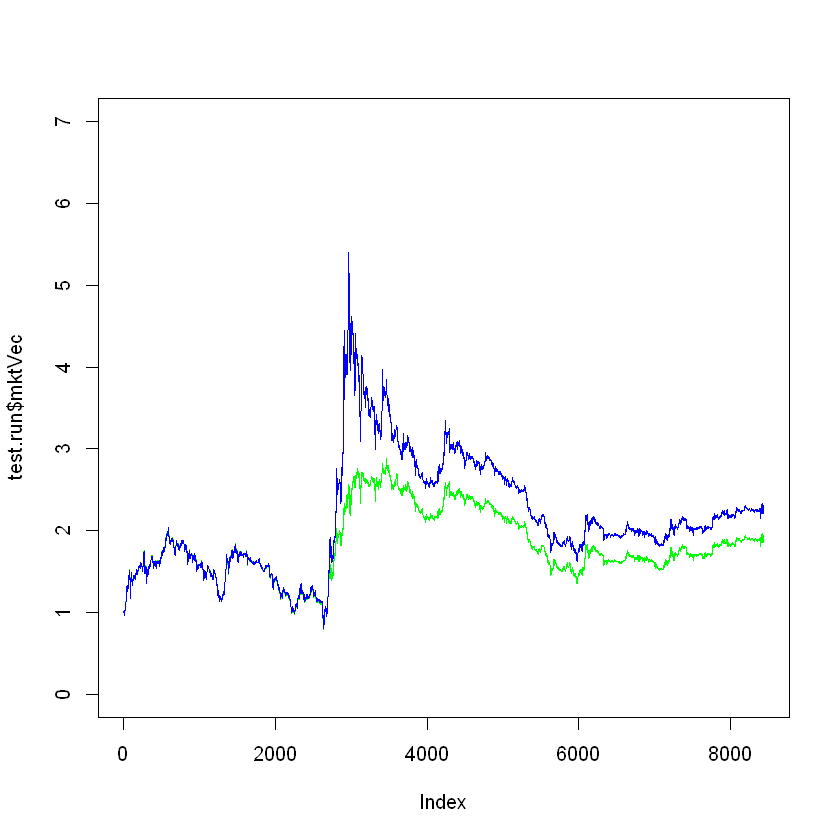

In [146]:
# Plot cummulative returns for agent and mkt
plot(test.run$mktVec,type="l",col="green",ylim=c(0,7))
lines(test.run$AgentVec,type="l",col="blue")

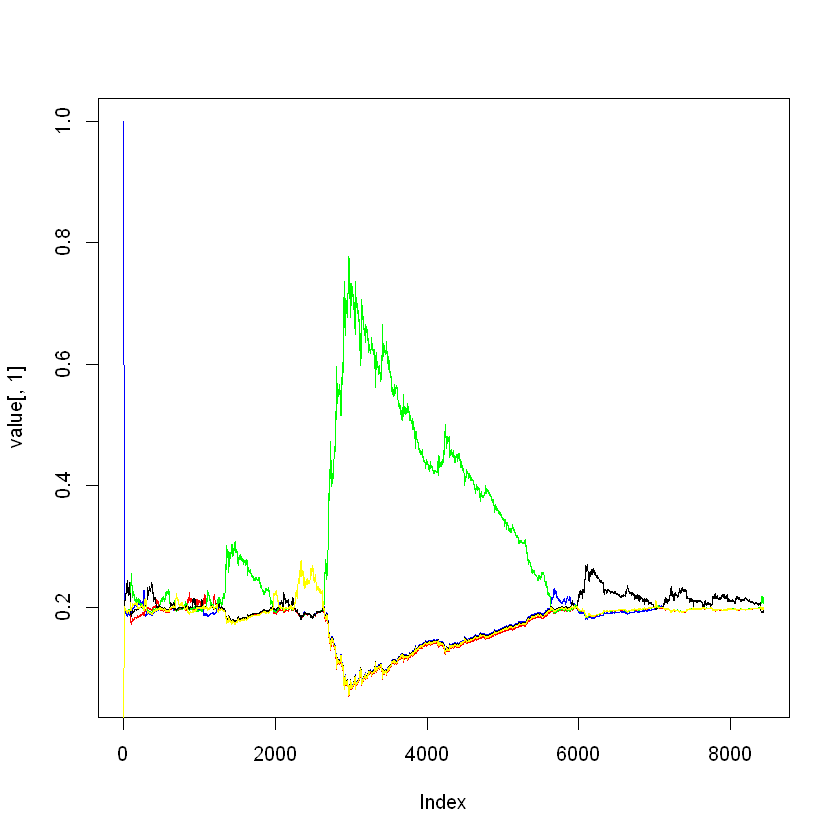

In [147]:
plot_graph <- function(run,arg){
    value <- run[[arg]]
    plot(value[,1],type="l",col="blue")
    lines(value[,2],type="l",col = "red")
    lines(value[,3],type="l",col = "green")
    lines(value[,4],type="l",col = "black")
    lines(value[,5],type="l",col = "yellow")
}

plot_graph(test.run,"actions")

In [148]:
test.run <- simulate_contextual1(5,nrow(close),0.8,10,0.8)

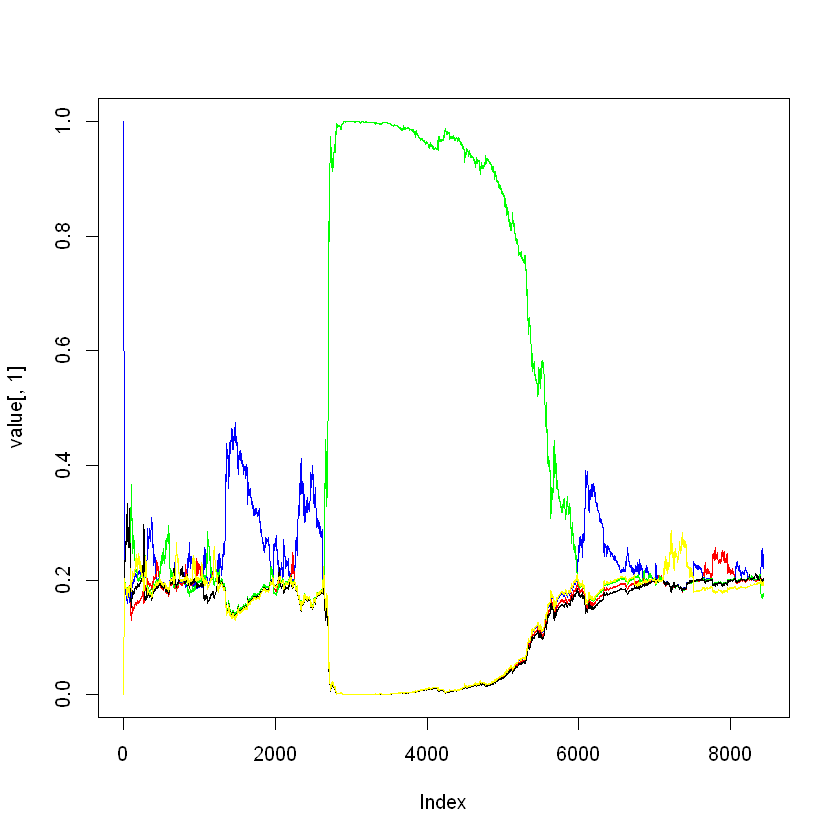

In [151]:
plot_graph(test.run,"actions")

In [107]:
# simulates contextual bandits problem
# This time action preferences are updated as if we pull all bandits and each timestep
# This is because we have full information of the environment
# params
# n_curren: number of currencies in proble (including cash)
# n_steps: number of timesteps in the episode
# alpha: learning rate of the action preference functions
# window_size: size of rolling window of asset prices to consider in the action preferences
# discount: discount factor of previous price changes
simulate_contextual2 <- function(n_curren,n_steps,alpha,window_size,discount){
  Ht <- rep(0,5) # initialize preference vector
  # initialize matrices
  piMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
  hMat <- matrix(Ht,nrow=1,byrow=T)
  yMat <- matrix(rep(0,n_curren),nrow=1,byrow=T)
  # Initialize weight vector for moving average window
  weight_vec <- c()
  for(k in 0:(window_size-1))
    weight_vec <- c(weight_vec,discount^k)
  weight_vec <- rev(weight_vec)
  
  price <- head(close,window_size+1) # initializes the price dataframe as the first 2 price vectors
  
  # history vector of price changes
  history <- getPriceRelativeVec(price[1,],price[2,])
  for(h in 2:window_size){
    history <- rbind(history,getPriceRelativeVec(price[h,],price[h+1,]))
  }
  
  # Define state st as vector of discounted previous relative changes
  st <- weight_vec %*% history
  
  prev_v <- tail(price,1) # initializes first price vector v
  
  # Define reward vecs and random action reward vectors
  Rvec <- c()
  Rvec_random <- c()
  Rvec_market <- c()
  market_average <- rep(1/5,5)
  Rmat <- matrix(0,nrow=1,ncol=n_curren)

  for(i in window_size:n_steps){
    # get price dataframe of current time step
    price <- head(close,i+2)
    # get the current v
    curr_v <- tail(price,1)
    # get price change
    yt <- getPriceRelativeVec(prev_v,curr_v)
    
    # update history matrix
    history <- rbind(tail(history,window_size-1),yt)
    
    # preference vector for state s (element-wise multiplication of Ht and st)
    Ht_s <- st * Ht
    
    # Compute pivec (softmaxes for each currency)
   
    piVec <- c()
    for(a in 1:n_curren)
      piVec <- c(piVec,get_softmax(a,Ht_s))
    
    # get the log returns for our action (in this case our action is the softax)
    rt <- exp(getLogReturns(yt,piVec))
    Rvec <- c(Rvec,rt)
    
    # get the log returns for pulling each arm
    Rvec_bandits <- c()
    for(a in 1:n_curren)
      Rvec_bandits <- c(Rvec_bandits,log(yt[a]))
    
    # update preference vector
    Ht <- get_update_all_bandits(Rvec_bandits,Rmat,Ht,alpha)
    
    # check if we are at first timestep, and if so, initialize Rmat, else append to Rmat
    if(i == window_size)
      Rmat <-  matrix(Rvec_bandits,nrow=1,ncol=n_curren)
    else
      Rmat <- rbind(Rmat,Rvec_bandits)
    
    # Reward for random action
    Rvec_random <- c(Rvec_random,exp(getLogReturns(yt,random_action(4))))
    
    # Reward for market average
    Rvec_market <- c(Rvec_market,exp(getLogReturns(yt,market_average)))
    
    # update prevsous price and state
    prev_v <- curr_v
    st <- weight_vec %*% history
    # append to matrices
    piMat <- rbind(piMat,piVec)
    hMat <- rbind(hMat,Ht)
    yMat <- rbind(yMat,yt)

  }
 
  return_list <- list(prod(Rvec),prod(Rvec_market),piMat,hMat,yMat, cumprod(Rvec),cumprod(Rvec_market))
  names(return_list) <- c("AgentRt","mktAve","actions","prefs","changes","AgentVec","MktVec")

  return(return_list)
}

In [116]:
ctxt2 <- simulate_contextual2(5,nrow(close),0.05,10,0.8)

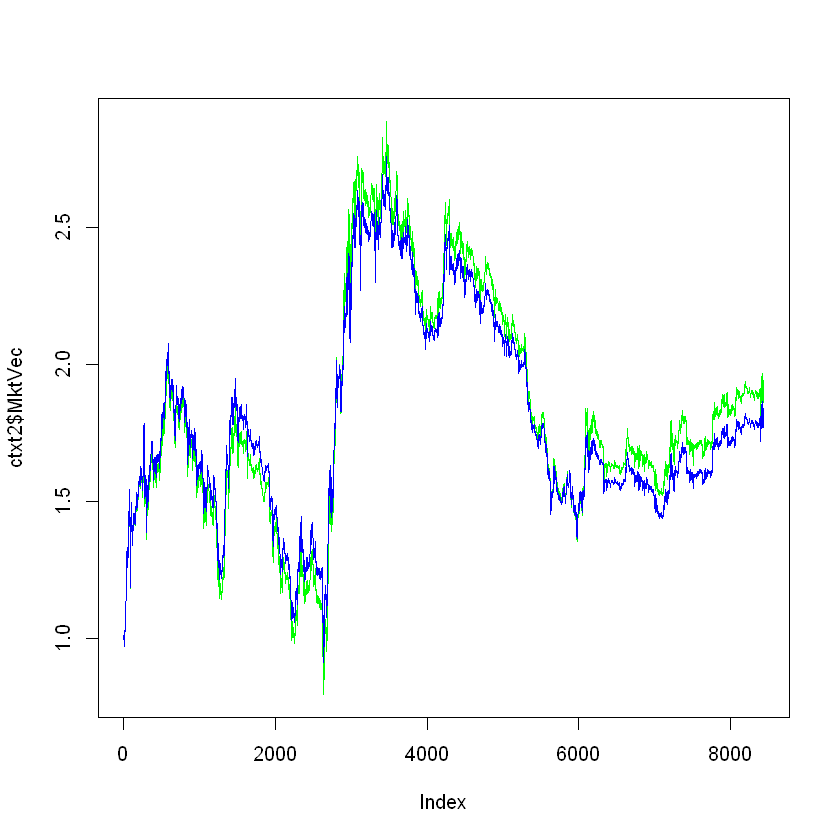

In [117]:
plot(ctxt2$MktVec,type="l",col="green")
lines(ctxt2$AgentVec,type="l",col="blue")

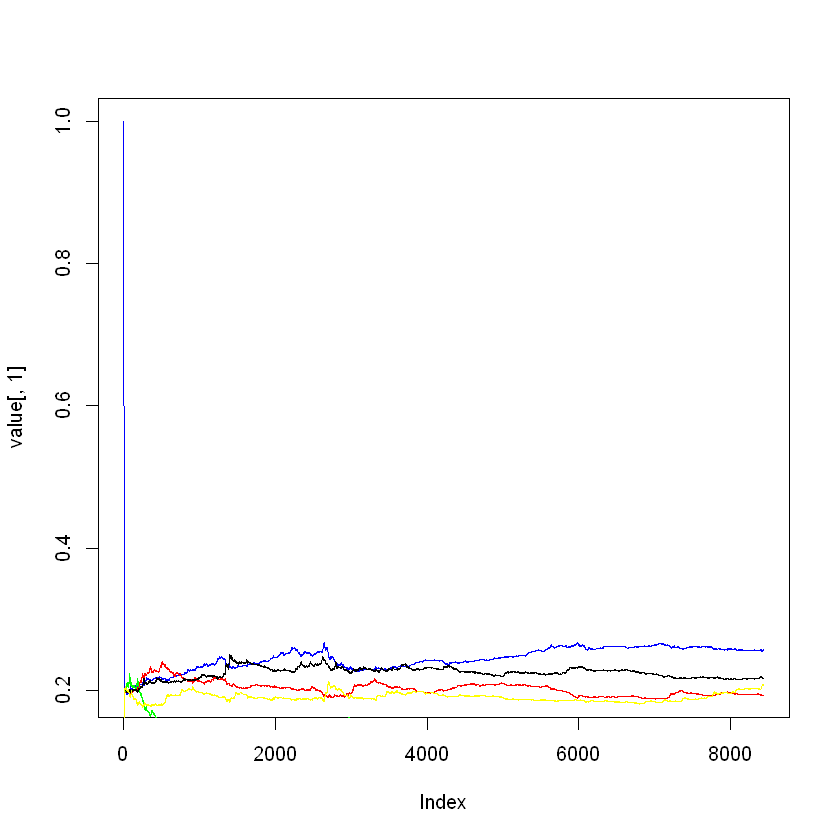

In [142]:
plot_graph(ctxt2,"actions")

In [132]:
# simulates contextual bandits problem strategy 3
# This is the all-in method, at each step we put all our assets into one cryptocrreuncy, effectively 
# making this a contextual k-armed bandits problem where we pull one arm and one arm only
# params
# n_curren: number of currencies in proble (including cash)
# n_steps: number of timesteps in the episode
# alpha: learning rate of the action preference functions
# window_size: size of rolling window of asset prices to consider in the action preferences
# discount: discount factor of previous price changes
# epsilon: epsilon value for epsilon greedy
simulate_contextual3 <- function(n_curren,n_steps,alpha,window_size,discount,epsilon=0.5){
    
    Ht <- rep(0,5) # initialize preference vector
    
    # Initialize weight vector for moving average window
    weight_vec <- c()
    for(k in 0:(window_size-1))
        weight_vec <- c(weight_vec,discount^k)
    weight_vec <- rev(weight_vec)
    
    price <- head(close,window_size+1) # initializes the price dataframe as the first 2 price vectors
    #st <- getPriceRelativeVec(price[1,],price[2,]) # get first price relative vector (first state)
    
    # history vector of price changes
    history <- getPriceRelativeVec(price[1,],price[2,])
    for(h in 2:window_size){
        history <- rbind(history,getPriceRelativeVec(price[h,],price[h+1,]))
    }
    
    # Define state st as vector of discounted previous relative changes
    st <- weight_vec %*% history
    
    prev_v <- tail(price,1) # initializes first price vector v
    
    # Define reward vecs and random action reward vectors
    Rvec <- c()
    Rvec_random <- c()
    Rvec_market <- c()
    market_average <- rep(1/5,5)
    
    # initialize matrices
    piMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
    hMat <- matrix(Ht,nrow=1,byrow=T)
    yMat <- matrix(rep(0,n_curren),nrow=1,byrow=T)
    aMat <- matrix(c(1,0,0,0,0),nrow=1,byrow=T)
    
    for(i in window_size:n_steps){
        # get price dataframe of current time step
        price <- head(close,i+2)
        # get the current v
        curr_v <- tail(price,1)
        # get price change
        yt <- getPriceRelativeVec(prev_v,curr_v)
        
        # update history matrix
        history <- rbind(tail(history,window_size-1),yt)
        
        # preference vector for state s (element-wise multiplication of Ht and st)
        Ht_s <- st * Ht
        
        # Compute pivec (softmaxes for each currency)
        piVec <- c()
        for(a in 1:n_curren)
            piVec <- c(piVec,get_softmax(a,Ht_s))
        
        if(runif(1) < epsilon)
            # do random action
            action <- sample(seq(1,n_curren),1)
        else
            # get the prefered action
            action <- which.max(piVec)
        
        # define action vec (1 if action is argmax of softmax)
        action_vec <- rep(0,n_curren)
        action_vec[action] <- 1
        
        # get the log returns for our action (in this case our action is the argmax over a)
        rt <- exp(getLogReturns(yt,action_vec))
        Rvec <- c(Rvec,rt)
        
        # Reward for random action
        Rvec_random <- c(Rvec_random,exp(getLogReturns(yt,random_action(4))))
        
        # Reward for market average
        Rvec_market <- c(Rvec_market,exp(getLogReturns(yt,market_average)))
        
        # Update preference vector
        Ht <- get_update(rt,Rvec,Ht,action,alpha)
        
#         print(log(yt))
#         print(Ht)
#         print(piVec)
#         print("=========================================")
        
#         print(paste0("episode",i))
#         print(cat("Ht: ", Ht))
#         print(cat("Ht_s: ", Ht_s))
        # print(cat("piVec: ", piVec))
#         print(cat("rt: ", rt))
        # print("==============================")
        
        prev_v <- curr_v
        st <- weight_vec %*% history
        
        # append to matrices
        piMat <- rbind(piMat,piVec)
        hMat <- rbind(hMat,Ht)
        yMat <- rbind(yMat,yt)
        aMat <- rbind(aMat,action_vec)
            
    }
    
    # create returrn list
    return_list <- list(prod(Rvec),prod(Rvec_market),piMat,hMat,yMat,cumprod(Rvec),cumprod(Rvec_market),aMat)
    names(return_list) <- c("AgentRt","mktAve","softmax","prefs","changes","AgentVec","mktVec","actions")
    
    return(return_list)
    
}

In [169]:
ctxt3 <- simulate_contextual3(5,nrow(close),0.8,10,0.8,0.5)

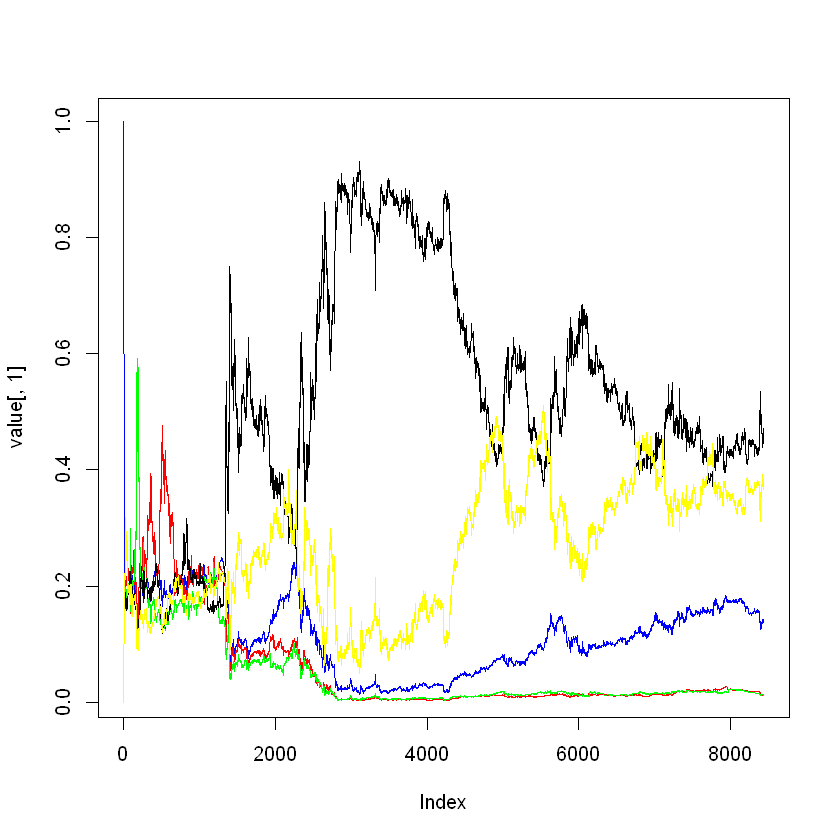

In [170]:
plot_graph(ctxt3,"softmax")

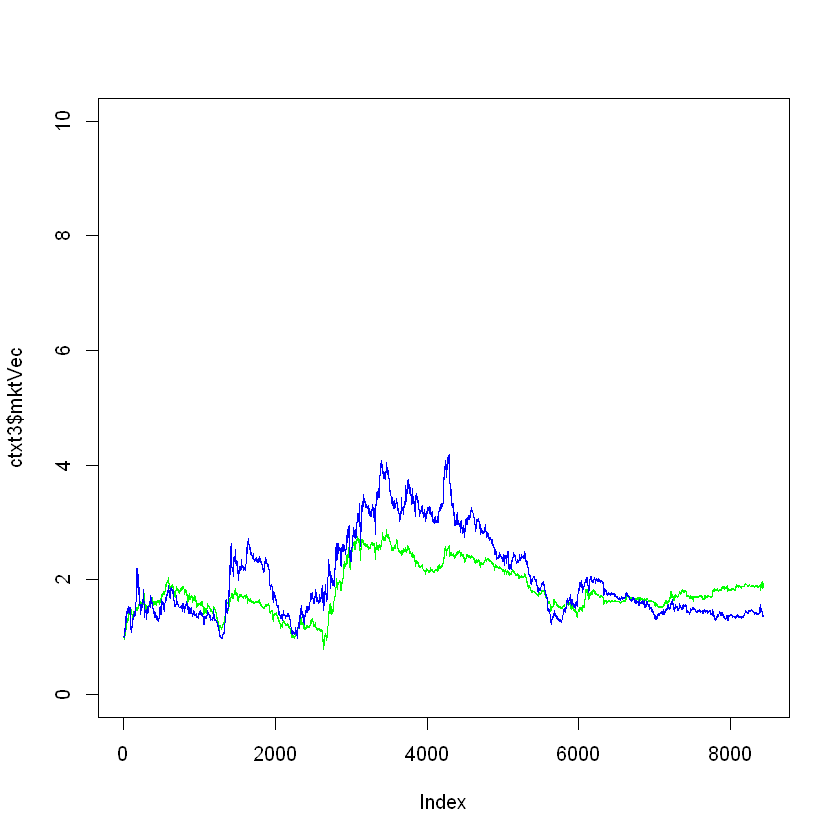

In [171]:
plot(ctxt3$mktVec,type="l",col="green",ylim = c(0,10))
lines(ctxt3$AgentVec,type="l",col="blue")

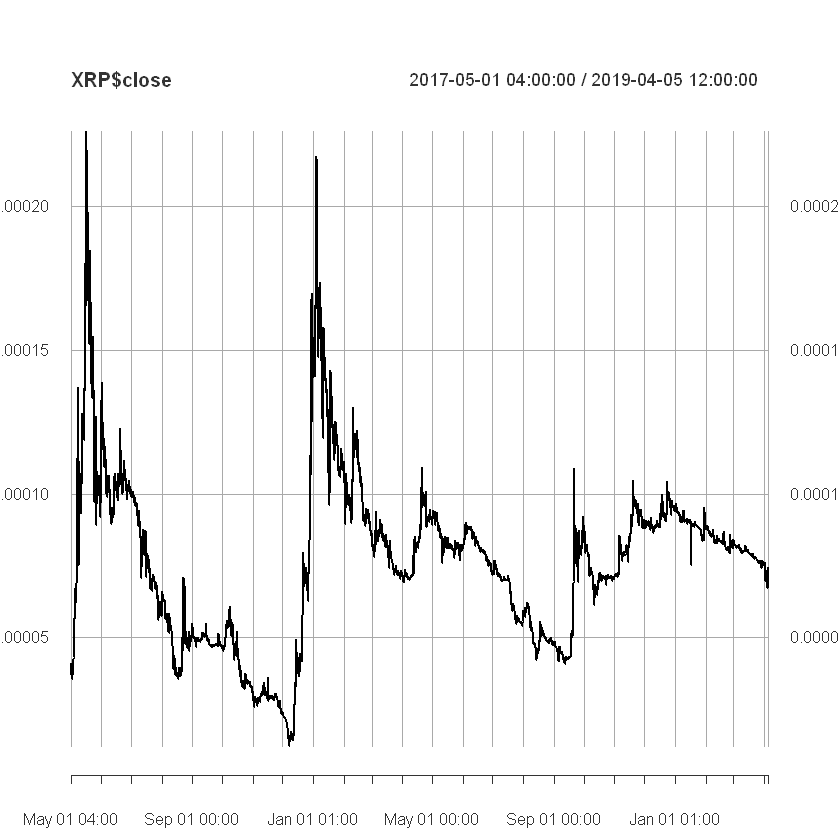

In [156]:
plot(XRP$close)